When searching for networks using AMC, we need to be able to rank discovered-networks by their accuracy.  In reality, we use a multi-objective (such as accuracy and latency) for produce a reward signal to the agent, but we always need to know how well the discovered networks perform their classification task.  We don't need to know the "true Top1" accuracy of the models (the accuracy of the model trained to convergence): we just need to be able to rank them, in a stable manner.  For example, imagine we've discovered two networks in our search: netA and netB.   NetA gives us a low predicted-accuracy signal ("search-Top1"), and NetB gives us a high predicted-accuracy.  If NetA's true-Top1 is smaller than NetB's true-Top1, and this property holds for most pairs of discovered networks, then the ranking is considered stable.

#### Question: 
* Does FM-reconstruction improve the stability of model ranking?

#### Method:
* Use an agent with a random policy, so the RL agent does not play a role. 
* Compare the ranking stability when using FM-reconstruction vs. when using fine-tuning.

#### Baseline:
* L1 ranking with Random agent
* 1 FT epoch

#### Test:
* Reconstruction with Random agent
* 1 FT epoch

In [3]:
%matplotlib inline

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc
from scipy.stats.stats import pearsonr

EXPERIMENTS_DIR = os.path.join("/experiments", "amc")

**Baseline**

    time python3 ../../classifier_compression/multi-run.py experiments/plain20-random-l1_rank compress_classifier.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=l1-rank --amc-agent-algo=Random-policy --amc-cfg=../automated_deep_compression/auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1

==> classifier_compression/experiments/plain20-random-l1_rank/2019.07.21-004045

    time python multi-finetune.py --scan-dir=experiments/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --ft-epochs=1 --output-csv=ft_1epoch_results.csv

==> classifier_compression/experiments/plain20-random-l1_rank/2019.07.21-004045/ft_1epoch_results.csv

**Test**

    time python3 ../../classifier_compression/multi-run.py experiments/plain20-random-reconstruction_nondeterministic compress_classifier.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=Random-policy --amc-cfg=../automated_deep_compression/auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1

==> experiments/plain20-random-reconstruction/2019.07.22-120953/

    time python multi-finetune.py --scan-dir=experiments/plain20-random-reconstruction_nondeterministic/2019.07.23-124600 --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --ft-epochs=1 --output-csv=ft_1epoch_results.csv

---
#### NOTE

* We use ```multi-run.py``` to execute the experiment 4 times, and write the output of each experiment to a separate subdirectory of ```experiments/plain20-random-l1_rank/2019.07.21-004045```.
* Then we use `parallel-finetune.py` to traverse these subdirectories.
* In each experiement subdirectory there are checkpoints for each of the best discovered networks.  Each time we find a network that performs better than the best network discovered so far (as measured by our multi-objective), we save the checkpoint of that netowrk.
* Script `parallel-finetune.py` will run a fine-tuning (re-training) session of each of the network-checkpoint files and write the accuracy and other metadata of each fine-tuned network to a CSV file.
* So if we execute 4 experiments using `multi-run.py`, then the CSV file should have the results for checkpoints of each of these 4 experiments.

In [5]:
df_baseline = pd.read_csv(os.path.join(EXPERIMENTS_DIR,
                                       "plain20-random-l1_rank",
                                       "2019.07.21-004045",
                                       "ft_1epoch_results.csv"))
df_thesis = pd.read_csv(os.path.join(EXPERIMENTS_DIR,
                                     "plain20-random-reconstruction_nondeterministic",
                                     "2019.07.23-124600",
                                     "ft_1epoch_results.csv"))

#### Answer:

* When using L1-ranking (with no FT during the RL search process) with a Random agent, there is no corralation between the search Top1 accuracy used as reward, and the Top1 after 1 epoch of FT.
* When using FM-reconstruction, search Top1 scores below ~15% show no corralation to the Top1 after 1 epoch of FT, but higher search Top1 scores show much better corralation (to be measured).

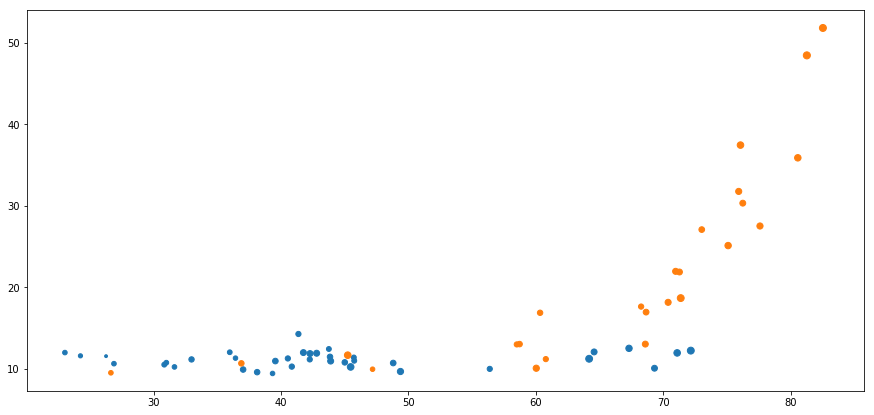

In [6]:
plt.figure(figsize=(15,7))
plt.scatter(df_baseline.top1, df_baseline.search_top1, s=df_baseline.macs)
plt.scatter(df_thesis.top1, df_thesis.search_top1, s=df_thesis.macs)

#### Question:
* What happens if we fine-tune the discovered networks for a longer time?<br>
  NOTE: we fine-tune _AFTER_ the RL search is done, so this FT process does not help the agent.  And, in any case, we are using a random agent.

time python multi-finetune.py --scan-dir=experiments/plain20-random-reconstruction_nondeterministic/2019.07.23-124600 --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --ft-epochs=20 --output-csv=ft_20epoch_results.csv


#### Answer:
* Corralation improves the more we fine-tune the solution.
* But something interesting happens: the discovered networks that have search-Top1 below ~15% still have low ranking stability (i.e. they do not corrolate well with the "true Top1").

Pearson: 0.594


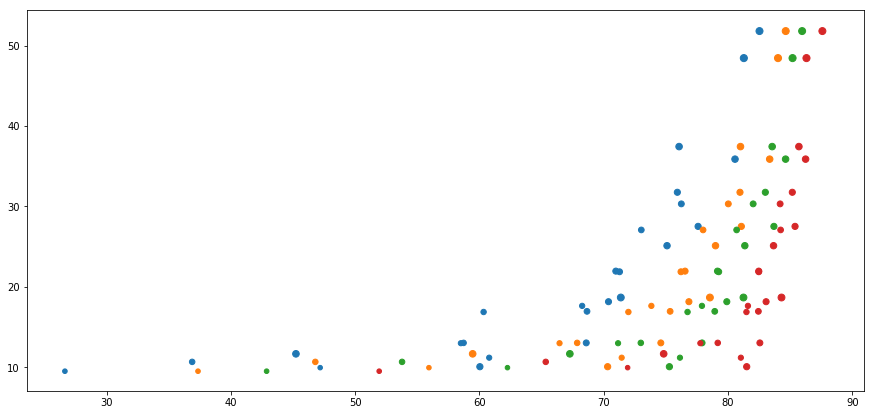

In [9]:
fpath = os.path.join(EXPERIMENTS_DIR, 
                     "plain20-random-reconstruction_nondeterministic",
                     "2019.07.23-124600")
df_thesis3 = pd.read_csv(os.path.join(fpath, "ft_3epoch_results.csv"))
df_thesis6 = pd.read_csv(os.path.join(fpath, "ft_6epoch_results.csv"))
df_thesis20 = pd.read_csv(os.path.join(fpath, "ft_20epoch_results.csv"))

plt.figure(figsize=(15,7))
plt.scatter(df_thesis.top1, df_thesis.search_top1, s=df_thesis.macs)
plt.scatter(df_thesis3.top1, df_thesis3.search_top1, s=df_thesis3.macs)
plt.scatter(df_thesis6.top1, df_thesis6.search_top1, s=df_thesis6.macs)
plt.scatter(df_thesis20.top1, df_thesis20.search_top1, s=df_thesis20.macs)


print("Pearson: %.3f" % pearsonr(df_thesis20.top1, df_thesis.search_top1)[0])

#### Question:

* What happens if we fine-tune the networks we discovered using l1-ranking (without FM reconstruction)?
* In other words, how many fine-tuning epochs do we need to perform during the RL search to get a cleaner, less noisy (i.e. more stable) search-Top1 (used in the multi-objective reward signal)?

    time python multi-finetune.py --scan-dir=experiments/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic **--ft-epochs=3** --output-csv=ft_3epoch_results.csv

    time python multi-finetune.py --scan-dir=experiments/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic **--ft-epochs=6** --output-csv=ft_6epoch_results.csv

    time python multi-finetune.py --scan-dir=experiments/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic **--ft-epochs=20** --output-csv=ft_20epoch_results.csv
    
## THIS IS IT
time python parallel-finetune.py --scan-dir=/experiments/amc/plain20-random-reconstruction_nondeterministic/2019.07.23-124600 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --epochs=60 --compress=../automated_deep_compression/plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --output-csv=ft_60epoch_results.csv --processes=16


#### Answer:

* Fine-tuning longer does not help increase the quality of the search-Top1 accuracy.

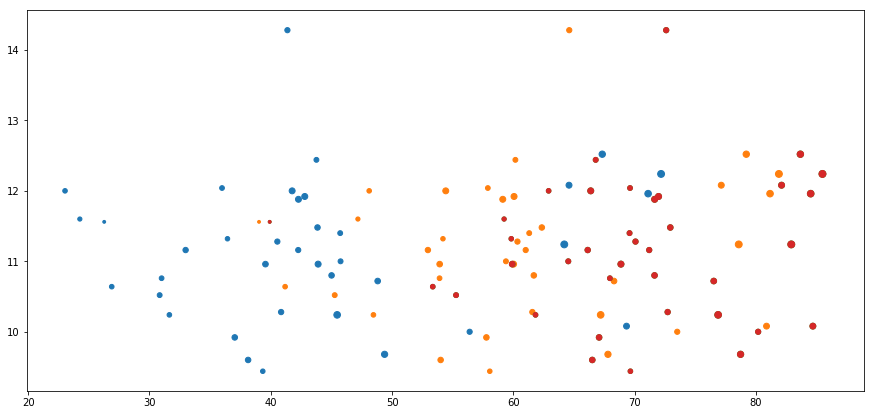

In [11]:
fpath = os.path.join(EXPERIMENTS_DIR, 
                     "plain20-random-l1_rank",
                     "2019.07.21-004045")

df_baseline6 = pd.read_csv(os.path.join(fpath, "ft_6epoch_results.csv"))
df_baseline20 = pd.read_csv(os.path.join(fpath, "ft_20epoch_results.csv"))
df_baseline60 = pd.read_csv(os.path.join(fpath, "ft_20epoch_results.csv"))

plt.figure(figsize=(15,7))

def plot_results(df):
    plt.scatter(df.top1, df.search_top1, s=df.macs)

for df in (df_baseline, df_baseline6, df_baseline20, df_baseline60):
    plot_results(df)


Best network: 72.17
Best network: 81.88
Best network: 85.47
Best network: 85.47


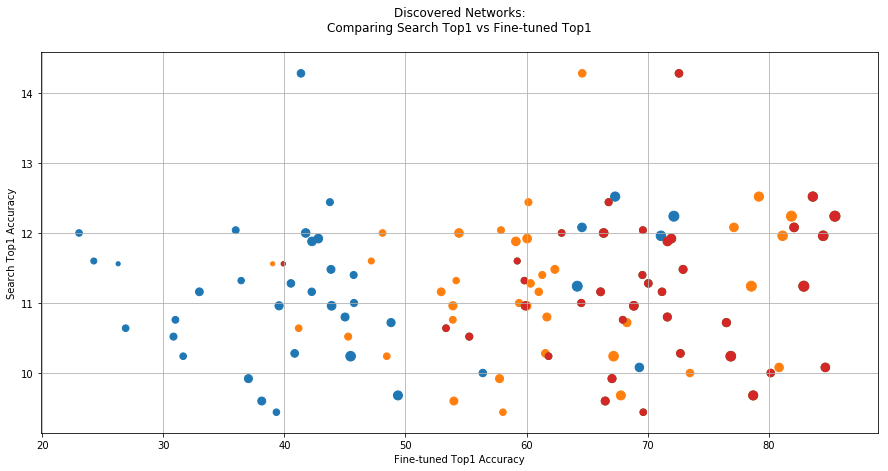

In [12]:
def create_fig(df):
    plt.figure(figsize=(15,7))
    cnt_nets = len(df.index)
    plt.grid(True)
    #plt.legend()
    plt.title("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n")
    plt.xlabel("Fine-tuned Top1 Accuracy")
    plt.ylabel("Search Top1 Accuracy")

def plot_networks2(df):
    size = df.macs / max(df.macs) * 100
    plt.scatter(df.top1, df.search_top1, s=size)
    print("Best network: %.2f" % max(df.top1))
    #print("Pearson: %.3f" % pearsonr(df.top1, df.search_top1)[0])
    df_sorted = df.sort_values(by=['top1'], inplace=False, ascending=False)
    # Five best
    #print(df_sorted[:5][['exp', 'search_top1', 'top1', 'name']])#[('name','top1')])
    
create_fig(df)
for df in (df_baseline, df_baseline6, df_baseline20, df_baseline60):
    plot_networks2(df)

## What happens when we randomly sample Resnet20 networks?


time python3 ../../classifier_compression/multi-run.py experiments/resnet20-random-reconstruction_nondeterministic amc.py --arch=resnet20_cifar ${CIFAR10_PATH} --resume=../../ssl/checkpoints/checkpoint_trained_dense.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=Random-policy --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1
 
 
 running on tab 3
